In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES
from anomaly.utils import line_width_from_velocity

In [2]:
# %%capture output
# set minor ticks on x axis as a default for all plots
# add minor ticks for all axes

def set_minorticks(axs):

    for ax in axs.flat:
        ax.minorticks_on()

In [3]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
# metric = "mse_filter_250kms_noRel100"
metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/"
    f"explanation/{model}/{metric}"
)

In [4]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")

anomalies = np.load(f"{data_directory}/top_anomalies.npy")

df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz",
    index_col="specobjid"
)

median_spectrum = np.load(
    f"{work_directory}/{bin_id}/median_spectrum.npy"
)
mean_spectrum = np.load(
    f"{work_directory}/{bin_id}/average_spectrum.npy"
)

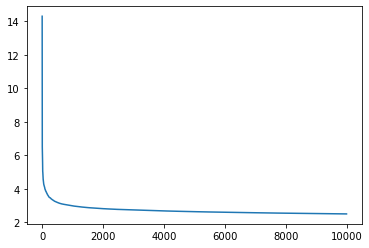

In [5]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

# Explore average patterns of all spectra and anomalies

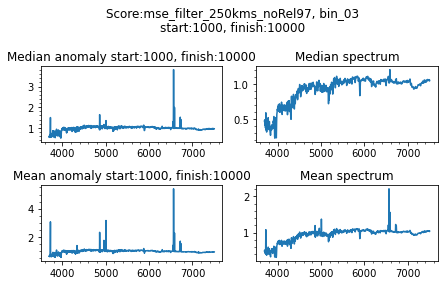

In [38]:
# average for anomalies from start_at to finish_at

# config
start_at = 1000
finish_at = 10_000

assert start_at < finish_at and finish_at <= 10_000

#########################################################################
median_anomaly = np.median(
    anomalies[start_at:finish_at, :],
    axis=0
)
mean_anomaly = np.mean(
    anomalies[start_at:finish_at, :],
    axis=0
)

# compare against mean and median spectra
fig, axs = plt.subplots(
    2, 2,
    figsize=None,
    tight_layout=True
)

# add minor ticks for all axes
set_minorticks(axs)

# add title to the figure
fig.suptitle(
    f"Score:{metric}, {bin_id}\n"
    f"start:{start_at}, finish:{finish_at}",
    fontsize=12
)

axs[0, 0].plot(wave, median_anomaly)
axs[0, 0].set_title(
    f"Median anomaly start:{start_at}, finish:{finish_at}"
)

axs[1, 0].plot(wave, mean_anomaly)
axs[1, 0].set_title(f"Mean anomaly start:{start_at}, finish:{finish_at}")

axs[0, 1].plot(wave, median_spectrum)
axs[0, 1].set_title("Median spectrum")

axs[1, 1].plot(wave, mean_spectrum)
axs[1, 1].set_title("Mean spectrum")

# save median and mean spectra for later use
np.save(
    f"{data_directory}/median_anomaly_"
    f"start_{start_at}_finish_{finish_at}_"
    f"{metric}_{bin_id}.npy",
    median_anomaly
)

np.save(
    f"{data_directory}/mean_anomaly_"
    f"start_{start_at}_finish_{finish_at}_"
    f"{metric}_{bin_id}.npy",
    mean_anomaly
)

# save figure to pdf in Downloads folder
fig.savefig(
    f"{data_directory}/mean_median_spectra_anomaly_"
    f"start_{start_at}_finish_{finish_at}_"
    f"{metric}_{bin_id}.pdf"
)

## Explore explanations

In [9]:
%%capture output
# config
median_smooth = True
drop_fraction = 0.05

# create array with weights for top all anomalies

explanations_directory = f"{data_directory}/000"

weights_all = np.empty(anomalies.shape)

for i, specobjid in enumerate(df_anomalies.index.to_numpy()):

    with open(
        f"{explanations_directory}/{specobjid}.pkl", "rb"
    ) as file:

        explanation = pickle.load(file)
        why = TellMeWhy(wave=wave, explanation=explanation)

        weights_all[i, :] = why.smooth_and_normalize_explanation(
            median_smooth=median_smooth,
            drop_fraction=drop_fraction 
        )

# new array to store the absolute values of the weights
weights_all_abs = np.abs(weights_all)

# save both arrays for later use
np.save(
    f"{data_directory}/weights_all_"
    f"smooth_{median_smooth}_drop_{drop_fraction}"
    f"{metric}_{bin_id}.npy",
    weights_all
)

np.save(
    f"{data_directory}/weights_all_abs_"
    f"smooth_{median_smooth}_drop_{drop_fraction}"
    f"{metric}_{bin_id}.npy",
    weights_all_abs
)

## Summary stats of explanation weights

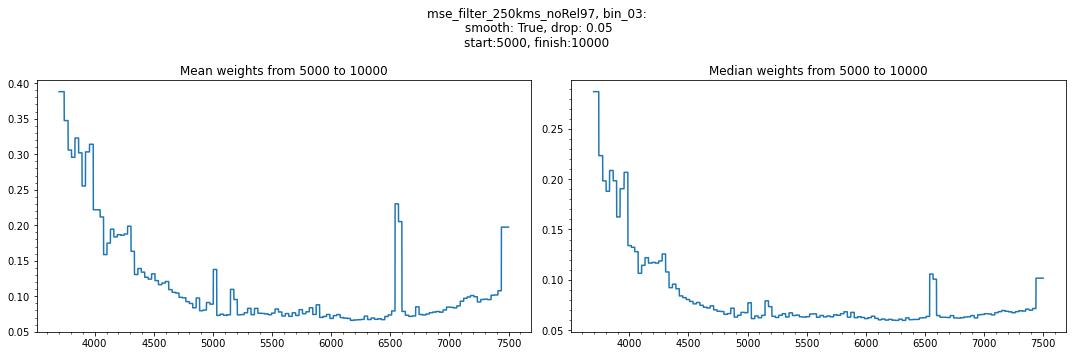

In [37]:
# mean and median of the explanation weights from start_at to finish_at
# config
start_at = 5000
finish_at = 10_000

assert start_at < finish_at and finish_at <= 10_000

#########################################################################
mean_weights_abs_sf = np.mean(
    weights_all_abs[start_at:finish_at, :],
    axis=0
)

median_weights_abs_sf = np.median(
    weights_all_abs[start_at:finish_at, :],
    axis=0
)


# plot the mean and median of the weights
fig, axs = plt.subplots(
    1, 2,
    figsize=(15, 5),
    tight_layout=True
)

# add title to the figure
fig.suptitle(
    f"{metric}, {bin_id}:\n"
    f" smooth: {median_smooth}, drop: {drop_fraction}\n"
    f"start:{start_at}, finish:{finish_at}",
    fontsize=12
)

# add minor ticks for all axes
set_minorticks(axs)

axs[0].plot(wave, mean_weights_abs_sf)
axs[0].set_title(f"Mean weights from {start_at} to {finish_at}")

axs[1].plot(wave, median_weights_abs_sf)
axs[1].set_title(f"Median weights from {start_at} to {finish_at}")

# save figure to pdf in data directory
fig.savefig(
    f"{data_directory}/mean_median_weights_abs_"
    f"from_{start_at}_to_{finish_at}_"
    f"smooth_{median_smooth}_drop_{drop_fraction}_"
    f"{metric}_{bin_id}.pdf"
)

## Analysis of raw values from explanation weights

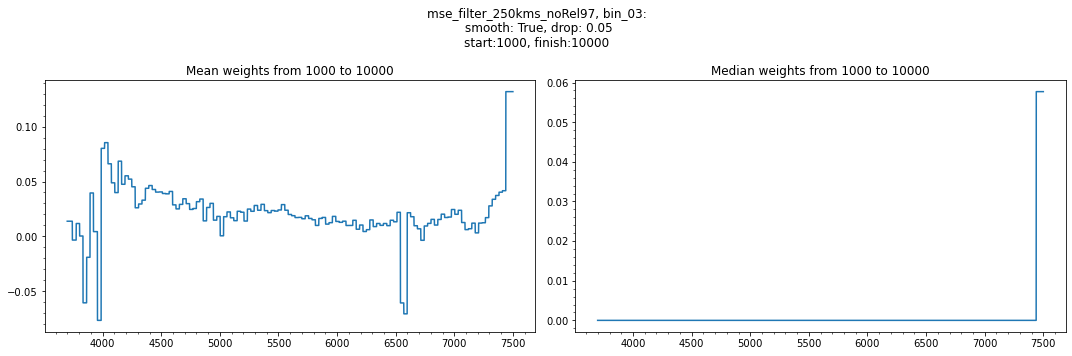

In [39]:
# mean and median of the explanation weights from start_at to finish_at
# config
start_at = 1000
finish_at = 10_000

assert start_at < finish_at and finish_at <= 10_000

#########################################################################

mean_weights_sf = np.mean(
    weights_all[start_at:finish_at, :],
    axis=0
)

median_weights_sf = np.median(
    weights_all[start_at:finish_at, :],
    axis=0
)


# plot the mean and median of the weights
fig, axs = plt.subplots(
    1, 2,
    figsize=(15, 5),
    tight_layout=True
)

# add title to the figure
fig.suptitle(
    f"{metric}, {bin_id}:\n"
    f" smooth: {median_smooth}, drop: {drop_fraction}\n"
    f"start:{start_at}, finish:{finish_at}",
    fontsize=12
)

# add minor ticks for all axes
set_minorticks(axs)

axs[0].plot(wave, mean_weights_sf)
axs[0].set_title(f"Mean weights from {start_at} to {finish_at}")

axs[1].plot(wave, median_weights_sf)
axs[1].set_title(f"Median weights from {start_at} to {finish_at}")

# save figure to pdf in data directory
fig.savefig(
    f"{data_directory}/mean_median_weights_"
    f"from_{start_at}_to_{finish_at}_"
    f"smooth_{median_smooth}_drop_{drop_fraction}_"
    f"{metric}_{bin_id}.pdf"
)